In [48]:
#double run the first command if it output an error
# We download the MNIST and Fashion-MNIST datasets from torchvision and apply a simple tensor transformation. 
# MNIST contains handwritten digit images, and Fashion-MNIST contains clothing images. 
# Both datasets will be used for training and evaluation later. 
# Important: 
# - Set 'download=True' so the data will be downloaded automatically if not found locally. 
# - Make sure the 'transform=transforms.ToTensor()' is used, because our models expect inputs in tensor format, not raw images.
# - The 'root' path './data' can be adjusted if you want to organize datasets differently.

In [14]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.ToTensor()

mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

fashion_train = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
fashion_test = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

In [20]:
# For the MNIST dataset, if print(len(mnist_train)) outputs 60000, it means the training data has been successfully downloaded as the MNIST training set officially contains 60,000 samples.

In [16]:
print(len(mnist_train))

60000


In [50]:
# We split the original MNIST training dataset into a new training set (90%) and a validation set (10%).
# Important:
# - Make sure to split before training so we can properly evaluate the model on unseen data during training.
# - We manually calculate the split sizes to ensure correct proportions.
# - This split is only applied to the training set; the original test set remains untouched for final evaluation.

In [22]:
from torch.utils.data import random_split

train_size = int(0.9 * len(mnist_train))  # 54000
val_size = len(mnist_train) - train_size  # 6000
mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

In [52]:
# We create DataLoaders for the training, validation, and test sets to efficiently load data in mini-batches.
# Important:
# - Set shuffle=True for the training DataLoader to randomize the order of samples, which helps the model generalize better.
# - Validation and test loaders use shuffle=False because we don't need to randomize data during evaluation.
# - The batch size is set to 64, but can be adjusted depending on memory and training speed.

In [24]:
from torch.utils.data import DataLoader

batch_size = 64  

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [54]:
# We define the LeNet model architecture here.
# It consists of two convolutional layers followed by three fully connected layers, using Tanh activation functions.
# Important:
# - The input images are expected to be 28x28 grayscale images (1 input channel).
# - After two rounds of convolution and pooling, the feature map size reduces to 4x4, which matches the first Linear layer.
# - The final output layer has 10 units, corresponding to the 10 classes in MNIST and Fashion-MNIST.

In [28]:
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5), 
            nn.Tanh(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.Tanh(),
            nn.AvgPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)  
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 16*4*4)
        x = self.fc(x)
        return x

In [56]:
# We prepare for training by setting up the device (GPU if available, otherwise CPU), 
# initializing the LeNet model, defining the loss function, and selecting the optimizer.
# Important:
# - Always move the model to the correct device (GPU if available) before training.
# - We use CrossEntropyLoss, which is standard for multi-class classification problems like MNIST.
# - The Adam optimizer is used for faster convergence, with a learning rate of 0.001 (can be adjusted later if needed).

In [30]:
import torch
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [35]:
train_losses = []
val_accuracies = []

In [46]:
# Training LeNet on MNIST.
# Loss will drop quickly at the beginning, then stabilize around a small value.
# Validation accuracy stays around 98%-99%, meaning the model has converged.
# We run 30 epochs to ensure full convergence before stopping.

In [36]:
num_epochs = 30 

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total

    train_losses.append(running_loss / len(train_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Accuracy: {val_acc:.4f}")

Epoch [1/30], Loss: 0.0025, Val Accuracy: 0.9883
Epoch [2/30], Loss: 0.0036, Val Accuracy: 0.9872
Epoch [3/30], Loss: 0.0057, Val Accuracy: 0.9867
Epoch [4/30], Loss: 0.0045, Val Accuracy: 0.9883
Epoch [5/30], Loss: 0.0015, Val Accuracy: 0.9877
Epoch [6/30], Loss: 0.0042, Val Accuracy: 0.9885
Epoch [7/30], Loss: 0.0065, Val Accuracy: 0.9883
Epoch [8/30], Loss: 0.0021, Val Accuracy: 0.9893
Epoch [9/30], Loss: 0.0034, Val Accuracy: 0.9835
Epoch [10/30], Loss: 0.0019, Val Accuracy: 0.9862
Epoch [11/30], Loss: 0.0035, Val Accuracy: 0.9885
Epoch [12/30], Loss: 0.0023, Val Accuracy: 0.9875
Epoch [13/30], Loss: 0.0063, Val Accuracy: 0.9857
Epoch [14/30], Loss: 0.0034, Val Accuracy: 0.9877
Epoch [15/30], Loss: 0.0023, Val Accuracy: 0.9870
Epoch [16/30], Loss: 0.0020, Val Accuracy: 0.9878
Epoch [17/30], Loss: 0.0026, Val Accuracy: 0.9877
Epoch [18/30], Loss: 0.0057, Val Accuracy: 0.9885
Epoch [19/30], Loss: 0.0029, Val Accuracy: 0.9872
Epoch [20/30], Loss: 0.0014, Val Accuracy: 0.9880
Epoch [21

In [58]:
# After training, we save the model's learned parameters (weights) to a file named 'lenet_mnist.pth'.
# Important:
# - We save only the model's state_dict (parameters), not the entire model structure.
# - To reuse the model later, we must first recreate the LeNet model and then load this saved state_dict.
# - Saving the model ensures we don't have to retrain from scratch every time.

In [42]:
torch.save(model.state_dict(), 'lenet_mnist.pth')

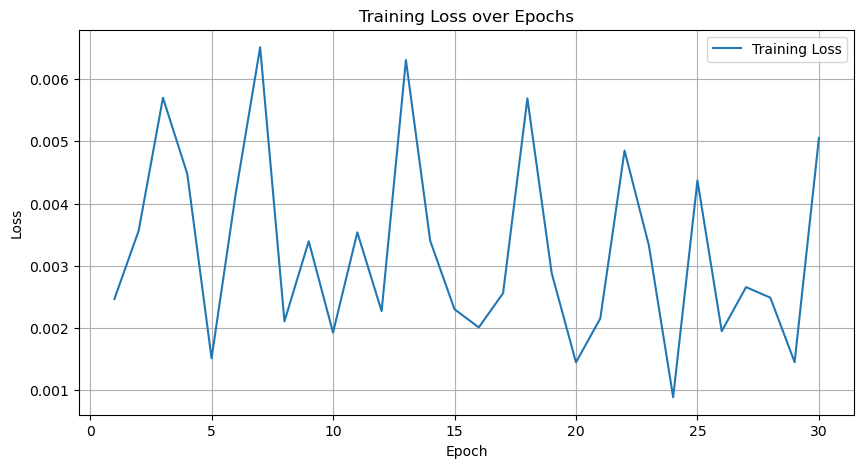

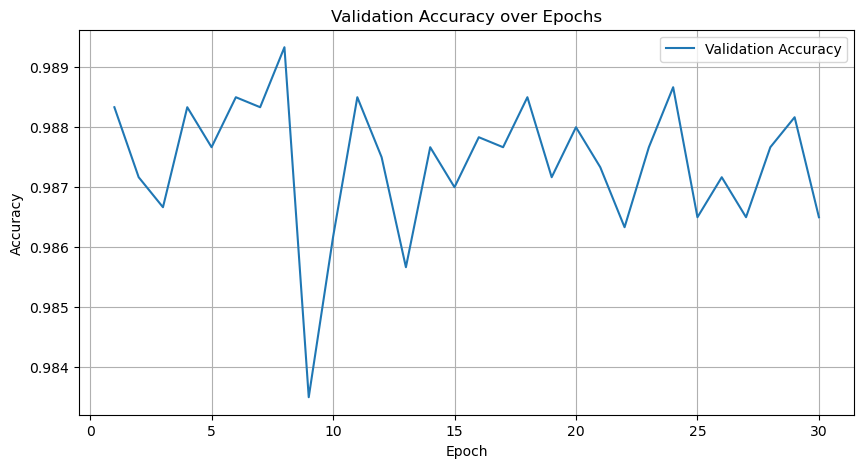

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()